## Relative Sizing of Cars

In [2]:
#Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torchvision import transforms, models
from PIL import Image
from pathlib import Path
import shutil


## **Section: Orientation Model**

### Load Orientation Model

In [ ]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_orientation_model(checkpoint_path):
    """
    Loads the trained orientation model from the given checkpoint path.
    """
    model = models.resnet18(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)  # Binary classification: left (0) vs. right (1)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    print(f"Model loaded from {checkpoint_path}")
    return model

# Example: Load the model
checkpoint_path = "../checkpoints/orientation_classifier_checkpoint.pth"
model = load_orientation_model(checkpoint_path)


### Predict Orientation

In [ ]:
def predict_orientation(model, image_path):
    """
    Predicts the orientation of the car in the image.
    Returns 'left' if the car faces left, 'right' if it faces right.
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        return "left" if predicted.item() == 0 else "right"


### Flip x-coordinates of Labels

In [ ]:
def flip_labels_x(label_path, output_label_dir):
    """
    Flips the x-coordinates of labels and saves them to a new directory.

    Parameters:
        label_path (str): Path to the original label file.
        output_label_dir (str): Directory to save the flipped labels.
    """
    os.makedirs(output_label_dir, exist_ok=True)

    flipped_labels = []
    with open(label_path, 'r') as f:
        for line in f:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            x_center = 1 - x_center  # Flip the x-coordinate
            flipped_labels.append(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    output_label_path = os.path.join(output_label_dir, os.path.basename(label_path))
    with open(output_label_path, 'w') as f:
        f.write("\n".join(flipped_labels))
    
    print(f"Flipped labels saved to {output_label_path}")


### Flip image

In [ ]:
def flip_image(image_path, output_image_dir):
    """
    Flips an image horizontally and saves it to the output directory.

    Parameters:
        image_path (str): Path to the original image.
        output_image_dir (str): Directory to save the flipped image.
    """
    os.makedirs(output_image_dir, exist_ok=True)

    image = cv2.imread(str(image_path))
    flipped_image = cv2.flip(image, 1)
    output_image_path = os.path.join(output_image_dir, os.path.basename(image_path))
    cv2.imwrite(output_image_path, flipped_image)
    
    print(f"Flipped image saved to {output_image_path}")
    return output_image_path


### Flip Images and Labels

In [ ]:
def flip_images_and_labels(model, images_dir, labels_dir, output_image_dir, output_label_dir):
    """
    Processes all images: identifies flipped images, flips them, and flips the labels' x-coordinates.

    Parameters:
        model (torch.nn.Module): Trained orientation model.
        images_dir (str): Directory containing the input images.
        labels_dir (str): Directory containing the label files.
        output_image_dir (str): Directory to save processed images.
        output_label_dir (str): Directory to save flipped labels.
    """
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    for image_path in Path(images_dir).glob("*.jpg"):
        label_path = Path(labels_dir) / f"{image_path.stem}.txt"
        
        if label_path.exists():
            # Predict orientation
            orientation = predict_orientation(model, str(image_path))
            flipped = False

            if orientation == "right":
                flipped = True
                # Flip the image and save
                flip_image(str(image_path), output_image_dir)
                # Flip the labels and save
                flip_labels_x(str(label_path), output_label_dir)
            else:
                # Copy the original image and label to the output directories
                shutil.copy(str(image_path), os.path.join(output_image_dir, image_path.name))
                shutil.copy(str(label_path), os.path.join(output_label_dir, label_path.name))
                print(f"Image and labels copied to {output_image_dir} and {output_label_dir}")
        else:
            print(f"Label file not found for {image_path}")


- example

In [ ]:
# Example usage
checkpoint_path = "../checkpoints/orientation_classifier_checkpoint.pth"
images_dir = "../data/processed/images_cropped"
labels_dir = "../data/processed/labels"
output_image_dir = "../data/output/wheel_images_flipped"
output_label_dir = "../data/output/wheel_labels_flipped"

model = load_orientation_model(checkpoint_path)

flip_images_and_labels(model, images_dir, labels_dir, output_image_dir, output_label_dir)


# **Section: Mask Scaling**

### Rim area

In [6]:

def calculate_rim_area_of_front_wheel(label_path, resolution=1024):
    """
    Returns {area} of front-wheel rim
    Important! Car nose should be pointing left
    
    Params:
    label_path: path of .txt files in Yolo format where class_id = 1 => rim
    resolution: resolution of image, default = 1024 (GP22 Dataset Standard)
    """
    smallest_x = float('inf')  
    smallest_box = None        

    with open(label_path, 'r') as file:
        for line in file:
            class_id, x_center, y_center, width, height = line.strip().split()
            if int(class_id) == 1:  # Only consider class_id = 1 (rim)
                x_center = float(x_center)
                if x_center < smallest_x:  
                    smallest_x = x_center
                    smallest_box = (float(width), float(height))

    if smallest_box:
        width, height = smallest_box
        area = width * height * (resolution ** 2) 
        return area
    else:
        return 0  # Return 0 if no class_id = 1 boxes are found


label_path = "../data/GP22/labels/A_Ast_01.txt"
print(f"{calculate_rim_area_of_front_wheel(label_path):.2f} pixels²")


18360.00 pixels²


### Scaling Factor

In [5]:
def compare_area(rim_area_reference_car, rim_area_current_car):
    """
    Calculate the scaling factor to adjust the dimensions of the current car
    so that its area matches the area of the reference car.

    Parameters:
    - rim_area_reference_car (float): The area of the reference car's bounding box.
    - rim_area_current_car (float): The area of the current car's bounding box.

    Returns:
    - scaling_factor (float): The factor by which the current car's dimensions 
                              (width and height) should be scaled.
    """
    if rim_area_reference_car <= 0 or rim_area_current_car <= 0:
        raise ValueError("Both areas must be positive numbers.")
    
    scaling_factor = (rim_area_reference_car / rim_area_current_car) ** 0.5
    
    return scaling_factor


### Scaling the Mask

In [4]:
def scale_mask(mask, scaling_factor):
    """
    Scales a binary mask by a given scaling factor.

    Parameters:
    - mask (numpy.ndarray): The input mask as a 2D binary array (1s and 0s).
    - scaling_factor (float): The factor by which to scale the mask dimensions.

    Returns:
    - scaled_mask (numpy.ndarray): The resized mask as a 2D binary array.
    """
    if scaling_factor <= 0:
        raise ValueError("Scaling factor must be a positive number.")

    # Get original dimensions
    original_height, original_width = mask.shape

    # Compute new dimensions
    new_width = int(original_width * scaling_factor)
    new_height = int(original_height * scaling_factor)

    # Resize the mask using OpenCV
    scaled_mask = cv2.resize(
        mask, (new_width, new_height), interpolation=cv2.INTER_NEAREST
    )

    # Ensure the scaled mask remains binary (0s and 1s)
    scaled_mask = (scaled_mask > 0).astype(np.uint8)

    return scaled_mask


- Example

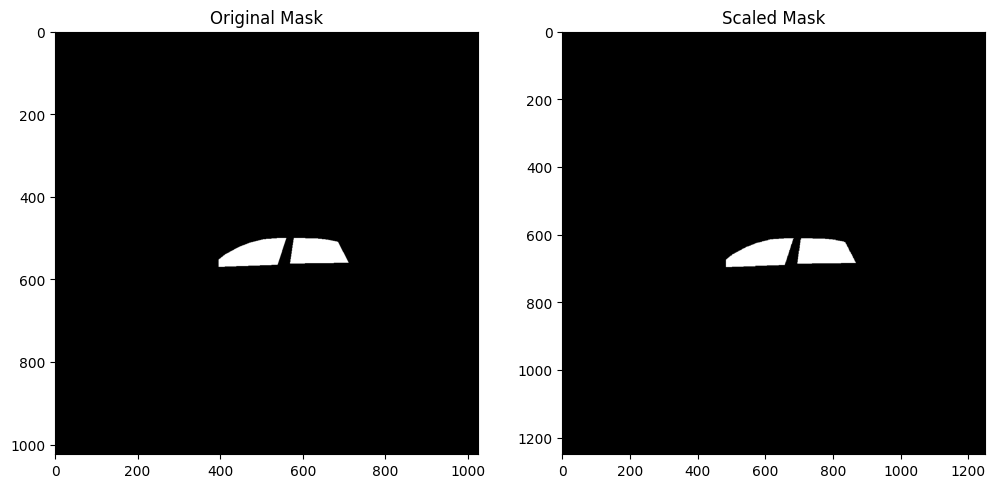

In [7]:
original_mask = cv2.imread("../data/with_labels/augmented/masks/D_Aud_24_aug_0.png", cv2.IMREAD_GRAYSCALE)
recently_scaled_mask = scale_mask(original_mask, 1.22)



# Set up the figure and subplots
plt.figure(figsize=(12, 6))

# Display the original mask
plt.subplot(1, 2, 1)
plt.imshow(original_mask, cmap="gray")
plt.title("Original Mask")
plt.axis("on")

# Display the scaled mask
plt.subplot(1, 2, 2)
plt.imshow(recently_scaled_mask, cmap="gray")
plt.title("Scaled Mask")
plt.axis("on")

# Show the plot with both masks
plt.show()

# **Section: Pipeline**

### Scale All Cars by Single Reference Car

In [52]:
def process_all_masks_and_labels(reference_label_path, masks_folder, labels_folder, output_folder, resolution=1024): 
    """
    Processes all the masks and labels in the given folder, calculates the area,
    compares it, and scales the masks, then saves the scaled masks to the output folder.
    
    Params:
    - masks_folder: Path to the folder containing the mask images.
    - labels_folder: Path to the folder containing the label text files.
    - output_folder: Path to the folder where the scaled masks will be saved.
    - resolution: Resolution of the images (default 1024).
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Assuming you have a reference car (e.g., the first label file)
    reference_area = calculate_rim_area_of_front_wheel(reference_label_path, resolution)
    
    if reference_area == 0:
        print("No valid reference area found.")
        return
    
    print(f"Reference car rim area: {reference_area:.2f} pixels²")
    
    # Loop through all the label files in the folder
    for label_file in os.listdir(labels_folder):
        if label_file.endswith(".txt"):
            label_path = os.path.join(labels_folder, label_file)
            print(f"Processing label: {label_file}")
            
            # Calculate the area for the current car
            current_area = calculate_rim_area_of_front_wheel(label_path, resolution)
            
            if current_area == 0:
                print(f"Skipping {label_file} due to no valid rim area.")
                continue
            
            # Compare areas and calculate scaling factor
            scaling_factor = compare_area(reference_area, current_area)
            print(f"Scaling factor for {label_file}: {scaling_factor:.2f}")
            
            # Find the corresponding mask for the current label file
            mask_name = label_file.replace(".txt", "_aug_0.png")  # Add "_aug_0" to the mask name
            mask_path = os.path.join(masks_folder, mask_name)
            
            if not os.path.exists(mask_path):
                print(f"Mask file {mask_path} does not exist. Skipping.")
                continue
            
            # Read the original mask
            original_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            if original_mask is None:
                print(f"Failed to read mask: {mask_path}. Skipping.")
                continue
            
            print(f"Original mask dimensions: {original_mask.shape}")
            
            # Scale the mask
            scaled_mask = scale_mask(original_mask, scaling_factor)
            scaled_mask = (scaled_mask * 255).astype(np.uint8)

            if scaled_mask is None or scaled_mask.size == 0:
                print(f"Scaling failed for mask: {mask_path}. Skipping.")
                continue
            
            print(f"Scaled mask dimensions: {scaled_mask.shape}")
            
            # Save the scaled mask to the output folder
            output_mask_path = os.path.join(output_folder, mask_name)
            # Ensure forward slashes for relative paths
            output_mask_path = output_mask_path.replace("\\", "/")
            cv2.imwrite(output_mask_path, scaled_mask)
            print(f"Saved scaled mask for {label_file} to {output_mask_path}")


In [50]:
reference_label = "../data/GP22/labels/A_Ast_01.txt"
masks_folder = "../data/with_labels/augmented/masks"
labels_folder = "../data/GP22/labels"
output_folder = "../data/with_labels/augmented/scaled_masks"

# Call the function to process all the masks and labels and save them to the output folder
process_all_masks_and_labels(reference_label, masks_folder, labels_folder, output_folder)


Reference car rim area: 18360.00 pixels²
Processing label: A_Ast_01.txt
Scaling factor for A_Ast_01.txt: 1.00
Original mask dimensions: (1024, 1024)
Scaled mask dimensions: (1024, 1024)
Saved scaled mask for A_Ast_01.txt to ../data/with_labels/augmented/scaled_masks/A_Ast_01_aug_0.png
Processing label: A_Cit_01.txt
Scaling factor for A_Cit_01.txt: 0.98
Original mask dimensions: (1024, 1024)
Scaled mask dimensions: (1005, 1005)
Saved scaled mask for A_Cit_01.txt to ../data/with_labels/augmented/scaled_masks/A_Cit_01_aug_0.png
Processing label: A_Fia_01.txt
Scaling factor for A_Fia_01.txt: 1.38
Original mask dimensions: (1024, 1024)
Scaled mask dimensions: (1408, 1408)
Saved scaled mask for A_Fia_01.txt to ../data/with_labels/augmented/scaled_masks/A_Fia_01_aug_0.png
Processing label: A_Fia_02.txt
Scaling factor for A_Fia_02.txt: 1.06
Original mask dimensions: (1024, 1024)
Scaled mask dimensions: (1088, 1088)
Saved scaled mask for A_Fia_02.txt to ../data/with_labels/augmented/scaled_mask

### By Car Class

In [61]:
def process_masks_and_labels_by_class(classes, reference_cars, masks_folder, labels_folder, output_folder, resolution=1024):
    """
    Processes masks and labels grouped by class, scales masks based on reference cars for each class,
    and saves the scaled masks to the output folder.

    Params:
    - classes: List of car classes (e.g., ["A", "B", "C", ...]).
    - reference_cars: Dictionary mapping each class to its reference car label file.
    - masks_folder: Path to the folder containing the mask images.
    - labels_folder: Path to the folder containing the label text files.
    - output_folder: Path to the folder where the scaled masks will be saved.
    - resolution: Resolution of the images (default 1024).
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for car_class in classes:
        print(f"Processing class: {car_class}")
        class_output_folder = os.path.join(output_folder, car_class)
        if not os.path.exists(class_output_folder):
            os.makedirs(class_output_folder)

        reference_label_path = os.path.join(labels_folder, reference_cars[car_class])
        print("apapapapa " + reference_label)
        reference_area = calculate_rim_area_of_front_wheel(reference_label_path, resolution)

        if reference_area == 0:
            print(f"No valid reference area found for class {car_class}. Skipping class.")
            continue

        print(f"Reference rim area for class {car_class}: {reference_area:.2f} pixels²")

        # Process label files for the current class
        for label_file in os.listdir(labels_folder):
            if label_file.startswith(car_class) and label_file.endswith(".txt"):
                label_path = os.path.join(labels_folder, label_file)
                print(f"Processing label: {label_file}")

                current_area = calculate_rim_area_of_front_wheel(label_path, resolution)
                if current_area == 0:
                    print(f"Skipping {label_file} due to no valid rim area.")
                    continue

                scaling_factor = compare_area(reference_area, current_area)
                print(f"Scaling factor for {label_file}: {scaling_factor:.2f}")

                mask_name = label_file.replace(".txt", "_aug_0.png")
                mask_path = os.path.join(masks_folder, mask_name)

                if not os.path.exists(mask_path):
                    print(f"Mask file {mask_path} does not exist. Skipping.")
                    continue

                original_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if original_mask is None:
                    print(f"Failed to read mask: {mask_path}. Skipping.")
                    continue

                print(f"Original mask dimensions: {original_mask.shape}")
                scaled_mask = scale_mask(original_mask, scaling_factor)
                scaled_mask = (scaled_mask * 255).astype(np.uint8)
                
                if scaled_mask is None or scaled_mask.size == 0:
                    print(f"Scaling failed for mask: {mask_path}. Skipping.")
                    continue

                print(f"Scaled mask dimensions: {scaled_mask.shape}")
                output_mask_path = os.path.join(class_output_folder, mask_name).replace("\\", "/")
                cv2.imwrite(output_mask_path, scaled_mask)
                print(f"Saved scaled mask for {label_file} to {output_mask_path}")


In [62]:
classes = ["A", "B", "C", "D", "E", "F", "J", "M", "P", "S"]
reference_cars = {
    "A": "A_Hyu_05.txt",
    "B": "B_Maz_03.txt",
    "C": "C_Aud_10.txt",
    "D": "D_Aud_23.txt",
    "E": "E_Aud_05.txt",
    "F": "F_Hyu_02.txt",
    "J": "J_Ben_03.txt",
    "M": "M_Maz_02.txt",
    "P": "P_For_37.txt",
    "S": "S_Aud_17.txt",
    
}
masks_folder = "../data/with_labels/augmented/masks"
labels_folder = "../data/GP22/labels"
output_folder = "../data/with_labels/augmented/scaled_masks"

process_masks_and_labels_by_class(classes, reference_cars, masks_folder, labels_folder, output_folder)


Processing class: A
apapapapa ../data/GP22/labels/A_Ast_01.txt
Reference rim area for class A: 9120.00 pixels²
Processing label: A_Ast_01.txt
Scaling factor for A_Ast_01.txt: 0.70
Original mask dimensions: (1024, 1024)
Scaled mask dimensions: (721, 721)
Saved scaled mask for A_Ast_01.txt to ../data/with_labels/augmented/scaled_masks/A/A_Ast_01_aug_0.png
Processing label: A_Cit_01.txt
Scaling factor for A_Cit_01.txt: 0.69
Original mask dimensions: (1024, 1024)
Scaled mask dimensions: (708, 708)
Saved scaled mask for A_Cit_01.txt to ../data/with_labels/augmented/scaled_masks/A/A_Cit_01_aug_0.png
Processing label: A_Fia_01.txt
Scaling factor for A_Fia_01.txt: 0.97
Original mask dimensions: (1024, 1024)
Scaled mask dimensions: (992, 992)
Saved scaled mask for A_Fia_01.txt to ../data/with_labels/augmented/scaled_masks/A/A_Fia_01_aug_0.png
Processing label: A_Fia_02.txt
Scaling factor for A_Fia_02.txt: 0.75
Original mask dimensions: (1024, 1024)
Scaled mask dimensions: (767, 767)
Saved scale

: 